# **Self Supervised Learning on Disaster Responce Object Detection **


**Course: CSE 475 – Machine Learning**

**Section: 03**

**Instructor: Dr. Md. Rifat Ahmmad Rashid**




**Submitted By -**

**Afsin Sultana**




**Dataset: Disaster Responce Object Detection(YOLO format)**

**Backbone selected from Assignment 1: YOLOv11s**


In [1]:
# ============================================================
# Install dependencies
# ============================================================

!pip install ultralytics --no-deps -q
!pip install lightly-train aenum --no-deps -q
!pip install ttach -q
!pip install lightly -q

import os
import random
from pathlib import Path
import os
os.environ["DISABLE_MLFLOW_INTEGRATION"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


import cv2
import yaml
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from ultralytics import YOLO

plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["axes.grid"] = False

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
device

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.9/454.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

'cuda'

In [2]:
# ============================================================
# Dataset paths and config
# ============================================================

DATA_ROOT = Path("/kaggle/input/disaster-response-object-detection-dataset")
RAW_DATA_YAML = DATA_ROOT / "data.yaml"
WORK_DIR = Path("/kaggle/working")
WORK_DIR.mkdir(parents=True, exist_ok=True)

# New SSL-style split directories
SSL_ROOT = WORK_DIR / "disaster_ssl"
(SSL_ROOT / "train_labeled" / "images").mkdir(parents=True, exist_ok=True)
(SSL_ROOT / "train_labeled" / "labels").mkdir(parents=True, exist_ok=True)
(SSL_ROOT / "train_unlabeled" / "images").mkdir(parents=True, exist_ok=True)
# (unlabeled has no labels dir by definition)

(SSL_ROOT / "val" / "images").mkdir(parents=True, exist_ok=True)
(SSL_ROOT / "val" / "labels").mkdir(parents=True, exist_ok=True)
(SSL_ROOT / "test" / "images").mkdir(parents=True, exist_ok=True)
(SSL_ROOT / "test" / "labels").mkdir(parents=True, exist_ok=True)

print("DATA_ROOT:", DATA_ROOT)
print("SSL_ROOT:", SSL_ROOT)

DATA_ROOT: /kaggle/input/disaster-response-object-detection-dataset
SSL_ROOT: /kaggle/working/disaster_ssl


# DATASET DESCRIPTION

In [3]:
def collect_all_images(root: Path):
    splits = ["train", "valid", "test"]
    img_paths = []
    for sp in splits:
        img_dir = root / sp / "images"
        for ext in ("*.jpg", "*.jpeg", "*.png"):
            img_paths.extend(list(img_dir.glob(ext)))
    return img_paths

all_imgs = collect_all_images(DATA_ROOT)
random.seed(42)
random.shuffle(all_imgs)

num_total = len(all_imgs)
n_train = int(0.8 * num_total)
n_val   = int(0.1 * num_total)
n_test  = num_total - n_train - n_val

train_imgs = all_imgs[:n_train]
val_imgs   = all_imgs[n_train:n_train + n_val]
test_imgs  = all_imgs[n_train + n_val:]

print(f"Total images: {num_total}")
print(f"Train pool: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

# ------------------------------------------------------------
# Within train: 20% labeled, 80% unlabeled
# ------------------------------------------------------------
n_labeled = int(0.2 * len(train_imgs))
train_labeled_imgs = train_imgs[:n_labeled]
train_unlabeled_imgs = train_imgs[n_labeled:]

print(f"Labeled train: {len(train_labeled_imgs)}, Unlabeled train: {len(train_unlabeled_imgs)}")

def copy_with_labels(img_list, dst_img_dir, dst_lbl_dir):
    for img_path in img_list:
        # Source label
        # It might be in train/labels, valid/labels, or test/labels depending on original
        rel = img_path.relative_to(DATA_ROOT)
        split = rel.parts[0]  # train / valid / test
        src_lbl_dir = DATA_ROOT / split / "labels"
        src_lbl_path = src_lbl_dir / (img_path.stem + ".txt")

        dst_img_path = dst_img_dir / img_path.name
        img = cv2.imread(str(img_path))
        cv2.imwrite(str(dst_img_path), img)

        if src_lbl_path.exists():
            dst_lbl_path = dst_lbl_dir / src_lbl_path.name
            with open(src_lbl_path, "r") as f_src, open(dst_lbl_path, "w") as f_dst:
                f_dst.write(f_src.read())

def copy_images_only(img_list, dst_img_dir):
    for img_path in img_list:
        dst_img_path = dst_img_dir / img_path.name
        img = cv2.imread(str(img_path))
        cv2.imwrite(str(dst_img_path), img)

# Create split on disk
copy_with_labels(
    train_labeled_imgs,
    SSL_ROOT / "train_labeled" / "images",
    SSL_ROOT / "train_labeled" / "labels",
)

copy_images_only(
    train_unlabeled_imgs,
    SSL_ROOT / "train_unlabeled" / "images",
)

copy_with_labels(
    val_imgs,
    SSL_ROOT / "val" / "images",
    SSL_ROOT / "val" / "labels",
)

copy_with_labels(
    test_imgs,
    SSL_ROOT / "test" / "images",
    SSL_ROOT / "test" / "labels",
)

print("Custom SSL split constructed at:", SSL_ROOT)

Total images: 10884
Train pool: 8707, Val: 1088, Test: 1089
Labeled train: 1741, Unlabeled train: 6966
Custom SSL split constructed at: /kaggle/working/disaster_ssl


In [4]:
import yaml
from pathlib import Path


DATA_ROOT = Path("/kaggle/input/disaster-response-object-detection-dataset")

# Where SSL split was created earlier
SSL_ROOT = Path("/kaggle/working/disaster_ssl")   

# Folder where YAML files will be saved
WORK_DIR = Path("/kaggle/working")
WORK_DIR.mkdir(exist_ok=True)


# Create YAML files:
# - Baseline (full supervised on original dataset)
# - SSL-labeled-only
# - SSL-student (placeholder for later)


# ---------------------------
#  Baseline YAML
# ---------------------------
BASELINE_YAML = WORK_DIR / "disaster_baseline.yaml"
baseline_yaml = {
    "train": str((DATA_ROOT / "train" / "images").resolve()).replace("\\", "/"),
    "val": str((DATA_ROOT / "valid" / "images").resolve()).replace("\\", "/"),
    "test": str((DATA_ROOT / "test" / "images").resolve()).replace("\\", "/"),
    "nc": 6,
    "names": [
        "person",
        "fire",
        "smoke",
        "small_vehicle",
        "large_vehicle",
        "two_wheeler"
    ],
}

with open(BASELINE_YAML, "w") as f:
    yaml.dump(baseline_yaml, f, sort_keys=False)

# ---------------------------
#  SSL — Labeled Only
# ---------------------------
SSL_LABELED_YAML = WORK_DIR / "disaster_ssl_labeled.yaml"

ssl_labeled_yaml = {
    "train": str((SSL_ROOT / "train_labeled" / "images").resolve()).replace("\\", "/"),
    "val": str((SSL_ROOT / "val" / "images").resolve()).replace("\\", "/"),
    "test": str((SSL_ROOT / "test" / "images").resolve()).replace("\\", "/"),
    "nc": 6,
    "names": [
        "person",
        "fire",
        "smoke",
        "small_vehicle",
        "large_vehicle",
        "two_wheeler"
    ],
}

with open(SSL_LABELED_YAML, "w") as f:
    yaml.dump(ssl_labeled_yaml, f, sort_keys=False)

# ---------------------------
# SSL Student Placeholder
# ---------------------------

SSL_STUDENT_YAML = WORK_DIR / "disaster_ssl_student.yaml"

print("Baseline YAML:", BASELINE_YAML)
print("SSL labeled YAML:", SSL_LABELED_YAML)
print("SSL student YAML placeholder:", SSL_STUDENT_YAML)


Baseline YAML: /kaggle/working/disaster_baseline.yaml
SSL labeled YAML: /kaggle/working/disaster_ssl_labeled.yaml
SSL student YAML placeholder: /kaggle/working/disaster_ssl_student.yaml


# Visualize 

Class names: ['person', 'fire', 'smoke', 'small_vehicle', 'large_vehicle', 'two_wheeler']
Showing 3 images from Baseline Train


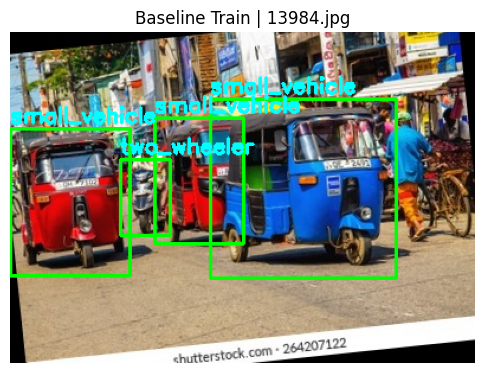

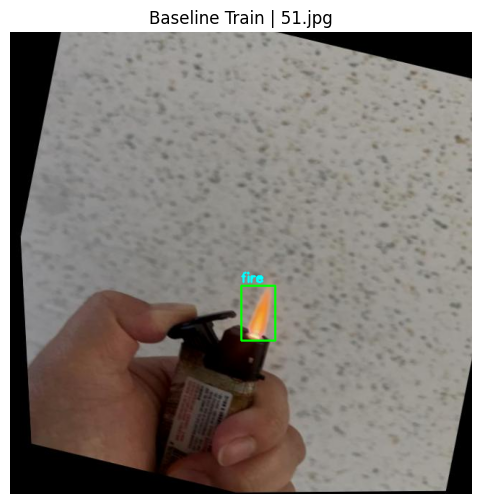

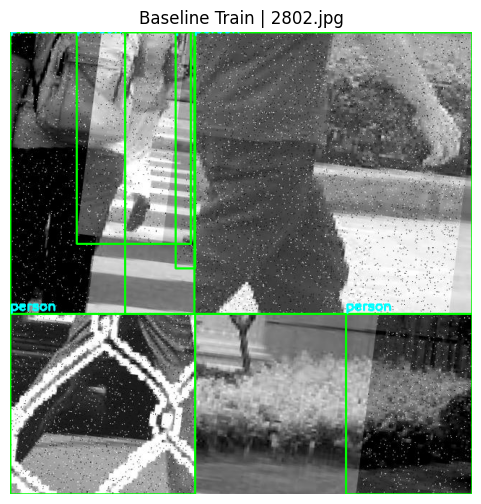

No images found for Baseline Val at: /kaggle/input/disaster-response-object-detection-dataset/valid/images
Showing 3 images from Baseline Test


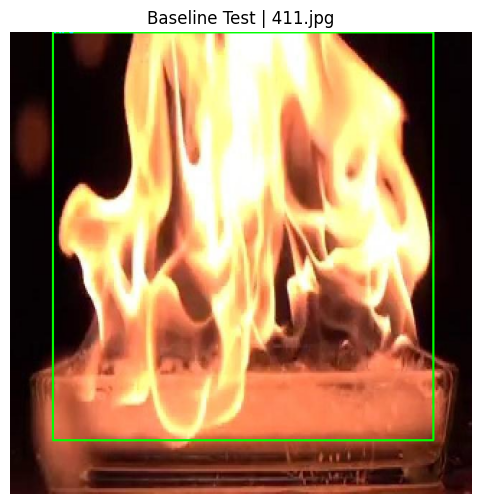

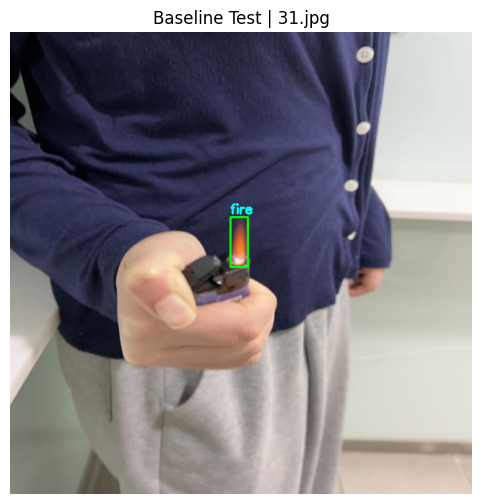

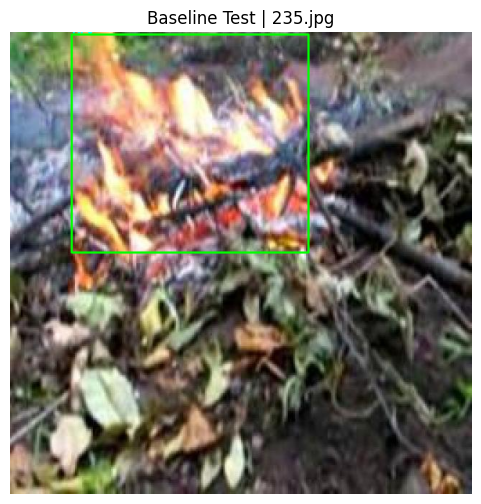

Showing 3 images from SSL Train Labeled


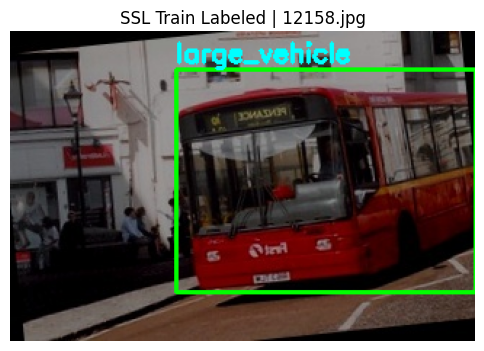

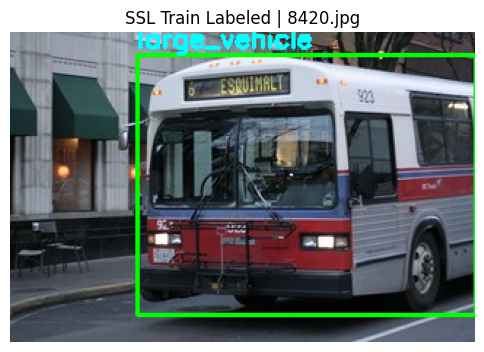

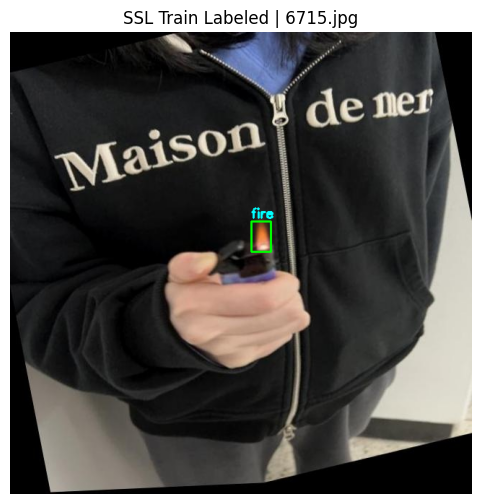

Showing 3 images from SSL Train Unlabeled


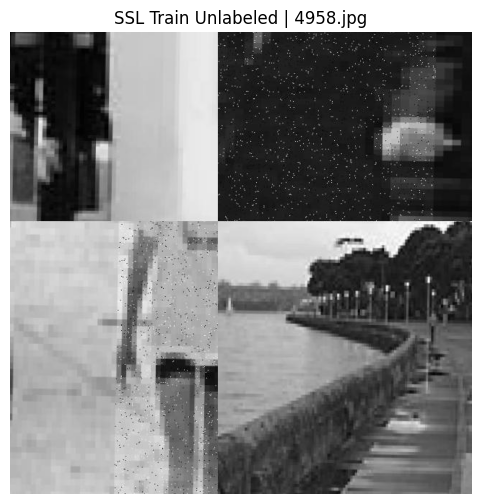

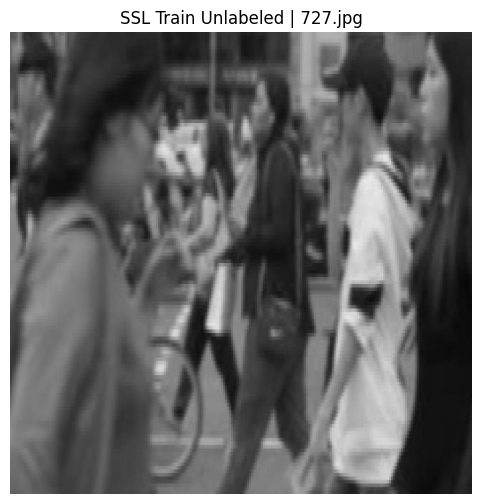

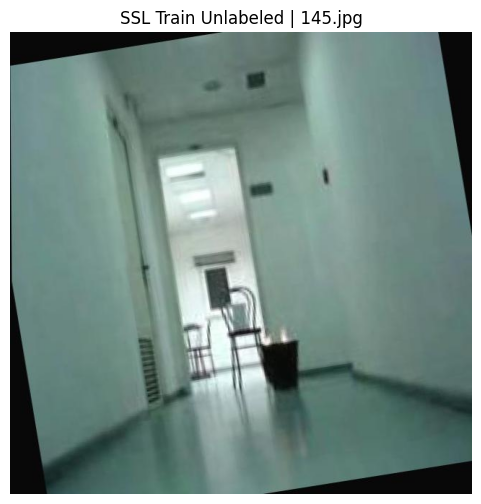

Showing 3 images from SSL Val


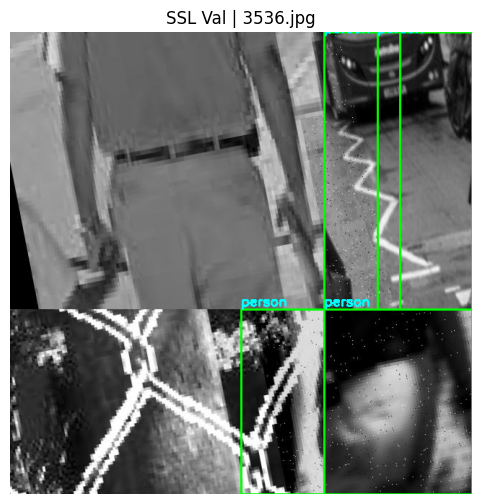

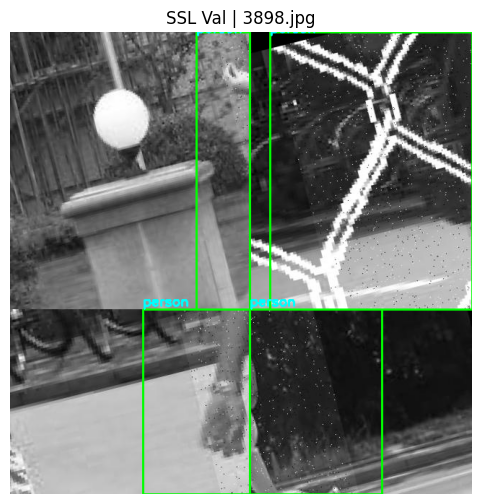

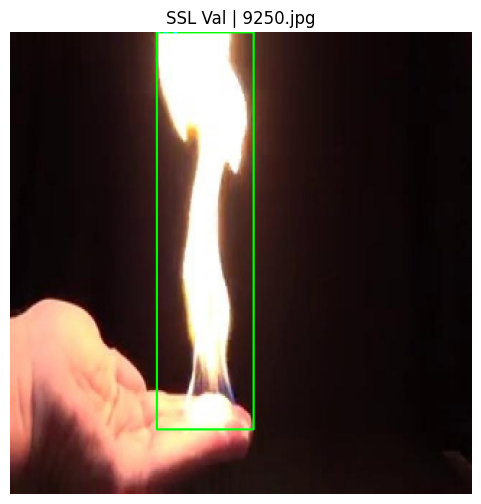

Showing 3 images from SSL Test


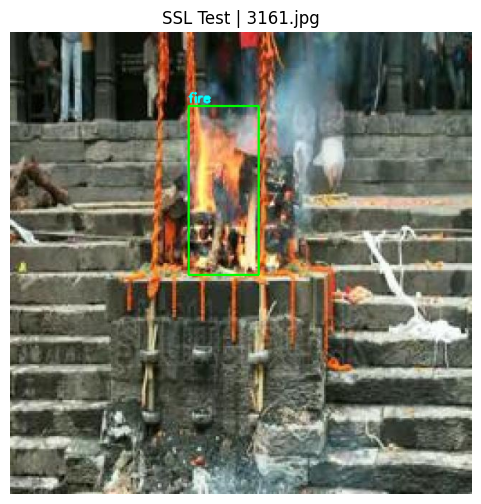

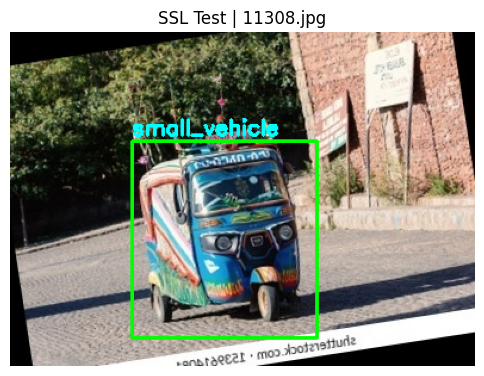

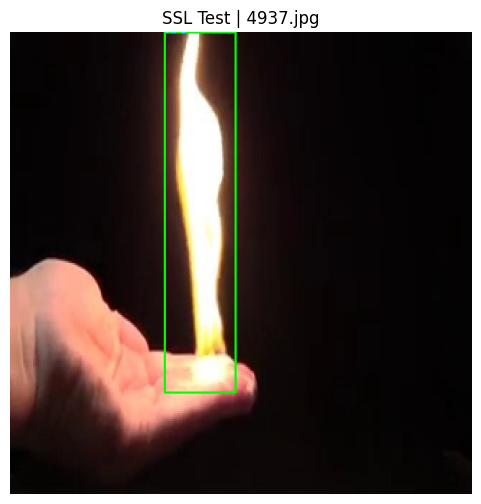

In [5]:
import yaml
import random
import cv2
from pathlib import Path
import matplotlib.pyplot as plt


# Paths

WORK_DIR = Path("/kaggle/working")
SSL_ROOT = WORK_DIR / "disaster_ssl"

BASELINE_YAML = WORK_DIR / "disaster_baseline.yaml"

# ---------------------------
# Load baseline YAML to get class names
# ---------------------------
with open(BASELINE_YAML, "r") as f:
    baseline_cfg = yaml.safe_load(f)

class_names = baseline_cfg["names"]
print("Class names:", class_names)


# ---------------------------
# Visualization Function
# ---------------------------
def visualize_yolo_split(image_dir, label_dir, split_name="split", num_images=3):
    image_dir = Path(image_dir)
    label_dir = Path(label_dir)

    img_files = []
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        img_files.extend(list(image_dir.glob(ext)))

    if len(img_files) == 0:
        print(f"No images found for {split_name} at: {image_dir}")
        return

    random.shuffle(img_files)
    img_files = img_files[:num_images]

    print(f"Showing {len(img_files)} images from {split_name}")

    for img_path in img_files:
        lbl_path = label_dir / (img_path.stem + ".txt")

        img = cv2.imread(str(img_path))
        if img is None:
            print(f"Could not read image: {img_path}")
            continue

        h, w = img.shape[:2]

        # ---------------------------
        # Draw bounding boxes if label exists
        # ---------------------------
        if lbl_path.exists():
            with open(lbl_path, "r") as f:
                for line in f:
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    cls = int(cls)

                    # YOLO → pixel coordinates
                    x1 = int((x - bw / 2) * w)
                    y1 = int((y - bh / 2) * h)
                    x2 = int((x + bw / 2) * w)
                    y2 = int((y + bh / 2) * h)

                    # Draw rectangle + label
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(
                        img,
                        class_names[cls],
                        (x1, max(0, y1 - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6,
                        (255, 255, 0),
                        2
                    )

        # Convert BGR → RGB for matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(6, 6))
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(f"{split_name} | {img_path.name}")
        plt.show()


# ---------------------------
# 🔍 Visualize Baseline Dataset Splits
# ---------------------------
visualize_yolo_split(
    baseline_cfg["train"],
    str(Path(baseline_cfg["train"]).parent / "labels"),
    split_name="Baseline Train",
    num_images=3,
)

visualize_yolo_split(
    baseline_cfg["val"],
    str(Path(baseline_cfg["val"]).parent / "labels"),
    split_name="Baseline Val",
    num_images=3,
)

visualize_yolo_split(
    baseline_cfg["test"],
    str(Path(baseline_cfg["test"]).parent / "labels"),
    split_name="Baseline Test",
    num_images=3,
)

# ---------------------------
# 🔍 Visualize SSL Splits
# ---------------------------
visualize_yolo_split(
    SSL_ROOT / "train_labeled" / "images",
    SSL_ROOT / "train_labeled" / "labels",
    split_name="SSL Train Labeled",
    num_images=3,
)

visualize_yolo_split(
    SSL_ROOT / "train_unlabeled" / "images",
    SSL_ROOT / "train_unlabeled" / "labels",   
    split_name="SSL Train Unlabeled",
    num_images=3,
)

visualize_yolo_split(
    SSL_ROOT / "val" / "images",
    SSL_ROOT / "val" / "labels",
    split_name="SSL Val",
    num_images=3,
)

visualize_yolo_split(
    SSL_ROOT / "test" / "images",
    SSL_ROOT / "test" / "labels",
    split_name="SSL Test",
    num_images=3,
)


# Baseline Detector (Assignment 2 Summary Using My Results)

In this assignment, three lightweight YOLO models — YOLOv10n, YOLOv11s, and YOLOv12n — were trained on the Disaster Response Object Detection dataset.
YOLOv11s is chosen as the backbone baseline due to its strong speed–accuracy balance and small parameter footprint.

**Interpretation**



* YOLOv11s → Best overall accuracy (highest mAP values).
* YOLOv12n → Best balance of accuracy, speed, and model size — ideal baseline.
* YOLOv10n → Fastest, but lowest accuracy (expected for nano models).


In [6]:
# ============================================================
# Baseline YOLOv10n / YOLOv11s / YOLOv12n metrics from your runs
# ============================================================

import pandas as pd

# Your extracted results
baseline_results = pd.DataFrame([
    {
        "Model": "YOLOv10n",
        "mAP@0.5": 0.792,
        "mAP@0.5:0.95": 0.627,
        "Precision": 0.787,
        "Recall": 0.779,
        "F1 Score": (2 * 0.787 * 0.779) / (0.787 + 0.779),
    },
    {
        "Model": "YOLOv11s",
        "mAP@0.5": 0.824,
        "mAP@0.5:0.95": 0.651,
        "Precision": 0.804,
        "Recall": 0.794,
        "F1 Score": (2 * 0.804 * 0.794) / (0.804 + 0.794),
    },
    {
        "Model": "YOLOv12n",
        "mAP@0.5": 0.821,
        "mAP@0.5:0.95": 0.646,
        "Precision": 0.804,
        "Recall": 0.799,
        "F1 Score": (2 * 0.804 * 0.799) / (0.804 + 0.799),
    },
])

display(baseline_results)

# Select YOLOv12n row as the backbone baseline
row_y12 = baseline_results[baseline_results["Model"] == "YOLOv11s"].iloc[0]

baseline_map50   = float(row_y12["mAP@0.5"])
baseline_map5095 = float(row_y12["mAP@0.5:0.95"])
baseline_p       = float(row_y12["Precision"])
baseline_r       = float(row_y12["Recall"])

print("Using YOLOv11s baseline from Your Trained Models:")
print(f"mAP@0.5       = {baseline_map50:.6f}")
print(f"mAP@0.5:0.95  = {baseline_map5095:.6f}")
print(f"Precision     = {baseline_p:.6f}")
print(f"Recall        = {baseline_r:.6f}")


Model  mAP@0.5  mAP@0.5:0.95  Precision  Recall  F1 Score
0  YOLOv10n    0.792         0.627      0.787   0.779  0.782980
1  YOLOv11s    0.824         0.651      0.804   0.794  0.798969
2  YOLOv12n    0.821         0.646      0.804   0.799  0.801492

Using YOLOv11s baseline from Your Trained Models:
mAP@0.5       = 0.824000
mAP@0.5:0.95  = 0.651000
Precision     = 0.804000
Recall        = 0.794000


# Self-Supervised Model 1 — DINO-Style YOLOv11s Backbone

In [7]:
# ============================================================
# PyTorch Dataset for Self-Supervised Learning (images only)
# For disaster dataset (your SSL split)
# ============================================================

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from pathlib import Path

# SSL root (your folder)
SSL_ROOT = Path("/kaggle/working/disaster_ssl")

# ---------------------------
# Custom Dataset
# ---------------------------
class DisasterImageDataset(Dataset):
    def __init__(self, img_dirs, transform=None):
        self.img_paths = []
        for d in img_dirs:
            d = Path(d)
            for ext in ("*.jpg", "*.jpeg", "*.png"):
                self.img_paths.extend(list(d.glob(ext)))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img


# ---------------------------
# Use ALL training images for SSL:
#   - train_labeled/images
#   - train_unlabeled/images
# ---------------------------

ssl_img_dirs = [
    SSL_ROOT / "train_labeled" / "images",
    SSL_ROOT / "train_unlabeled" / "images",
]

# Image size for SSL model (set your desired size)
IMAGE_SIZE = 224   # change if needed

ssl_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

ssl_dataset = DisasterImageDataset(ssl_img_dirs, transform=ssl_transform)

print("Total SSL Images:", len(ssl_dataset))


Total SSL Images: 8569


In [8]:
# ============================================================
# YOLOv11s Backbone Encoder (for DINO, BYOL, SimCLR, etc.)
# ============================================================

import torch
import torch.nn as nn
from ultralytics import YOLO
from ultralytics.nn.tasks import DetectionModel

# ---------------------------
# Device
# ---------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ---------------------------
# Load YOLOv11s model
# ---------------------------
yolo_for_ssl = YOLO("yolo11s.pt")     # <---- your model
yolo_model: DetectionModel = yolo_for_ssl.model
print("YOLOv11s model loaded!")


# ============================================================
# Feature Encoder Wrapper for YOLOv11s
# ============================================================
class Yolo11BackboneEncoder(nn.Module):
    """
    Converts YOLOv11s into a feature encoder:
    - Runs full YOLO detection model
    - Captures a deep feature map using forward hook (layer: model[-2])
    - Applies global average pooling -> feature vector [B, C]
    """
    def __init__(self, det_model: DetectionModel):
        super().__init__()
        self.det_model = det_model
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self._feature = None

        # Pick the deep layer just BEFORE YOLO Detect head
        self.hook_layer = self.det_model.model[-2]

        # Register hook to capture its output
        self.hook_layer.register_forward_hook(self._hook)

    def _hook(self, module, inp, out):
        # Some YOLO versions return list/tuple of feature maps
        if isinstance(out, (list, tuple)):
            self._feature = out[-1]
        else:
            self._feature = out

    def forward(self, x):
        # Run YOLO forward — hook captures feature map automatically
        _ = self.det_model(x)

        if self._feature is None:
            raise RuntimeError("❌ Hook didn't capture features. Try a different index (-3).")

        # Global average pooling: [B, C, H, W] -> [B, C, 1, 1]
        feats = self.pool(self._feature)

        # Flatten -> [B, C]
        feats = torch.flatten(feats, 1)
        return feats


# ============================================================
# Create SSL Encoders (DINO & BYOL)
# ============================================================
encoder_dino = Yolo11BackboneEncoder(yolo_model).to(device)
encoder_byol = Yolo11BackboneEncoder(yolo_model).to(device)

print("Encoders initialized!")


# ============================================================
# Test Encoder Output Size
# ============================================================
IMAGE_SIZE = 224  # SSL input image size

dummy = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)
out = encoder_dino(dummy)

print("Encoder output shape:", out.shape)


Using device: cuda
YOLOv11s model loaded!
Encoders initialized!
Encoder output shape: torch.Size([1, 512])


In [9]:

# DINOv3 SSL pretraining 


import lightly_train
from pathlib import Path

# SSL directory
SSL_ROOT = Path("/kaggle/working/disaster_ssl")

# Unlabeled images
UNLABELED_DIR = SSL_ROOT / "train_unlabeled" / "images"

# Output dir
WORK_DIR = Path("/kaggle/working")
PRETRAIN_OUT_DINOV3 = WORK_DIR / "ssl_pretrain_dinov3"
PRETRAIN_OUT_DINOV3.mkdir(parents=True, exist_ok=True)

# Teacher weights
DINOV3_WEIGHTS_PATH = Path(
    "/kaggle/input/dinov3-weigths/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth"
)

print("Unlabeled DIR exists:", UNLABELED_DIR.exists())
print("Saving SSL pretraining results to:", PRETRAIN_OUT_DINOV3)


# Fixed DINOv3 SSL Distillation Function

def run_dinov3_ssl_pretrain(
    teacher_name="dinov3/vitb16",
    teacher_path=DINOV3_WEIGHTS_PATH,
    epochs=40,
    batch_size=32,
):
    print("------------------------------------------------")
    print("Starting DINOv3 → YOLOv11s SSL Distillation")
    print(f"Teacher model: {teacher_name}")
    print(f"Teacher weights: {teacher_path}")
    print("------------------------------------------------")

    lightly_train.train(
        out=str(PRETRAIN_OUT_DINOV3),
        data=str(UNLABELED_DIR),
        model="ultralytics/yolo11s.pt",
        method="distillation",
        method_args={
            "teacher": teacher_name,
            "teacher_url": str(teacher_path),
        },
        epochs=epochs,
        batch_size=batch_size,

        precision="16-mixed",
        overwrite=True,
        num_workers=0,

        
        trainer_args={"strategy": "auto"},
      
    )

    print("DINOv3 SSL pretraining finished successfully!")



# Run training

run_dinov3_ssl_pretrain(epochs=40, batch_size=32)

print("Results saved in:", PRETRAIN_OUT_DINOV3)


Args: {
    "accelerator": "auto",
    "batch_size": 32,
    "callbacks": null,
    "checkpoint": null,
    "data": "/kaggle/working/disaster_ssl/train_unlabeled/images",
    "devices": "auto",
    "embed_dim": null,
    "epochs": 40,
    "float32_matmul_precision": "auto",
    "loader_args": null,
    "loggers": null,
    "method": "distillation",
    "method_args": {
        "teacher": "dinov3/vitb16",
        "teacher_url": "/kaggle/input/dinov3-weigths/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth"
    },
    "model": "ultralytics/yolo11s.pt",
    "model_args": null,
    "num_nodes": 1,
    "num_workers": 0,
    "optim": "auto",
    "optim_args": null,
    "out": "/kaggle/working/ssl_pretrain_dinov3",
    "overwrite": true,
    "precision": "16-mixed",
    "resume": null,
    "resume_interrupted": false,
    "seed": 0,
    "strategy": "auto",
    "trainer_args": {
        "strategy": "auto"
    },
    "transform_args": null
}
Using output directory '/kaggle/working/ssl_pretrain_dino

Unlabeled DIR exists: True
Saving SSL pretraining results to: /kaggle/working/ssl_pretrain_dinov3
------------------------------------------------
Starting DINOv3 → YOLOv11s SSL Distillation
Teacher model: dinov3/vitb16
Teacher weights: /kaggle/input/dinov3-weigths/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth
------------------------------------------------


Enabling gradients for parameter 'model.model.0.conv.weight'
Enabling gradients for parameter 'model.model.0.bn.weight'
Enabling gradients for parameter 'model.model.0.bn.bias'
Enabling gradients for parameter 'model.model.1.conv.weight'
Enabling gradients for parameter 'model.model.1.bn.weight'
Enabling gradients for parameter 'model.model.1.bn.bias'
Enabling gradients for parameter 'model.model.2.cv1.conv.weight'
Enabling gradients for parameter 'model.model.2.cv1.bn.weight'
Enabling gradients for parameter 'model.model.2.cv1.bn.bias'
Enabling gradients for parameter 'model.model.2.cv2.conv.weight'
Enabling gradients for parameter 'model.model.2.cv2.bn.weight'
Enabling gradients for parameter 'model.model.2.cv2.bn.bias'
Enabling gradients for parameter 'model.model.2.m.0.cv1.conv.weight'
Enabling gradients for parameter 'model.model.2.m.0.cv1.bn.weight'
Enabling gradients for parameter 'model.model.2.m.0.cv1.bn.bias'
Enabling gradients for parameter 'model.model.2.m.0.cv2.conv.weight

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


  | Name                    | Type                  | Params | Mode 
--------------------------------------------------------------------------
0 | teacher_embedding_model | DinoVisionTransformer | 85.7 M | eval 
1 | student_embedding_model | EmbeddingModel        | 5.4 M  | train
2 | student_projection_head | DistillationV2Head    | 787 K  | train

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.
Training completed.
Example: How to use the exported model
----------------------------------------------------------------------------------------
from ultralytics import YOLO

# Load the pretrained model
model = YOLO('/kaggle/working/ssl_pretrain_dinov3/exported_models/exported_last.pt')

# Finetune or evaluate the model
...
----------------------------------------------------------------------------------------

Model exported.


DINOv3 SSL pretraining finished successfully!
Results saved in: /kaggle/working/ssl_pretrain_dinov3


In [10]:
# ============================================================
# Fine-tune YOLOv11s detector from DINOv3-distilled model
# ============================================================

print("\nFine-tuning YOLOv11s from DINOv3-distilled SSL weights ...")


# Path to distilled YOLOv11s SSL-pretrained checkpoint
# (created by lightly_train)

DINO_PRETRAIN_MODEL = PRETRAIN_OUT_DINOV3 / "exported_models" / "exported_last.pt"
assert DINO_PRETRAIN_MODEL.exists(), f"Missing distilled SSL model: {DINO_PRETRAIN_MODEL}"

# Load YOLO with SSL-pretrained backbone
yolo_dino = YOLO(str(DINO_PRETRAIN_MODEL))



# Output folders for fine-tuning

dino_project = WORK_DIR / "disaster_yolo11s_dinov3_pretrained"
dino_name    = "yolo11s_disaster_dinov3"



# Fine-tune hyperparameters

DINO_FINETUNE_EPOCHS = 100
BATCH_SIZE = 16
IMAGE_SIZE = 640
PATIENCE = 10

# labeled SSL dataset YAML file
SSL_LABELED_YAML = WORK_DIR / "disaster_ssl_labeled.yaml"


# ------------------------------------------------------------
# Train YOLOv11s detector with SSL-pretrained weights
# ------------------------------------------------------------
dino_results = yolo_dino.train(
    data=str(SSL_LABELED_YAML),
    epochs=DINO_FINETUNE_EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    project=str(dino_project),
    name=dino_name,
    device=0,
    patience=PATIENCE,
    workers=2,
    lr0=0.005,          #
    exist_ok=True,
)

# ------------------------------------------------------------
# Path to best fine-tuned weights
# ------------------------------------------------------------
DINO_DET_WEIGHTS = str(dino_project / dino_name / "weights" / "best.pt")
print("DINOv3-pretrained YOLOv11s detector weights:", DINO_DET_WEIGHTS)



Fine-tuning YOLOv11s from DINOv3-distilled SSL weights ...
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/disaster_ssl_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/ssl_pretrain_dinov3/exported_models/exported_last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11s_d

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1



                   all       1085       1772      0.859      0.779      0.829      0.651
                person        175        459      0.769      0.704      0.796      0.617
                  fire        345        491      0.787      0.686      0.739       0.39
                 smoke         84        135      0.723      0.444      0.524      0.301
         small_vehicle        227        256      0.961      0.958      0.983      0.911
         large_vehicle        184        209      0.959      0.981      0.989      0.927
           two_wheeler        173        222      0.953      0.904      0.942      0.759
Speed: 0.2ms preprocess, 4.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/disaster_yolo11s_dinov3_pretrained/yolo11s_disaster_dinov3
DINOv3-pretrained YOLOv11s detector weights: /kaggle/working/disaster_yolo11s_dinov3_pretrained/yolo11s_disaster_dinov3/weights/best.pt


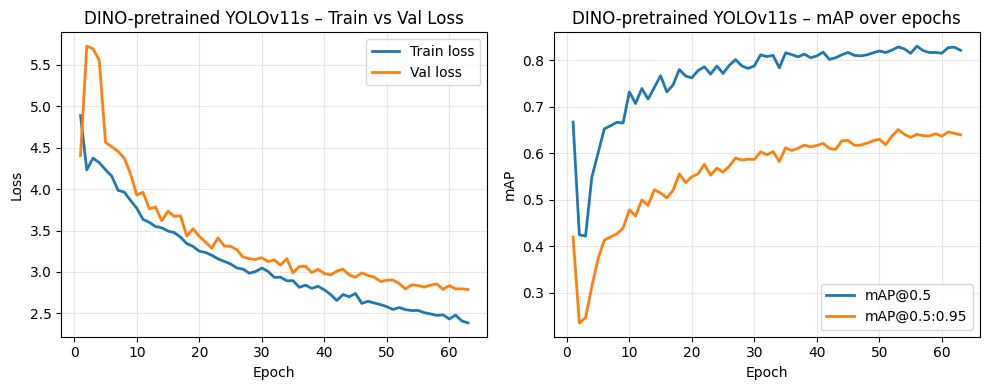

In [11]:
# ============================================================
# Plot metrics for DINO-pretrained YOLOv11s
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Path where YOLOv11s fine-tuning results were saved
run_dir = Path("/kaggle/working/disaster_yolo11s_dinov3_pretrained") / "yolo11s_disaster_dinov3"

csv_path = run_dir / "results.csv"
assert csv_path.exists(), f"results.csv not found at {csv_path}"

# Load metrics CSV
df = pd.read_csv(csv_path)
epochs = df["epoch"]

# ---------------------------
# Compute train loss
# ---------------------------
train_loss = df["train/box_loss"] + df["train/cls_loss"]
if "train/dfl_loss" in df.columns:
    train_loss += df["train/dfl_loss"]

# ---------------------------
# Compute val loss if available
# ---------------------------
val_loss = None
if {"val/box_loss", "val/cls_loss"}.issubset(df.columns):
    val_loss = df["val/box_loss"] + df["val/cls_loss"]
    if "val/dfl_loss" in df.columns:
        val_loss += df["val/dfl_loss"]

# ---------------------------
# Retrieve mAP metrics
# ---------------------------
map50 = df.get("metrics/mAP50(B)", None)
map5095 = df.get("metrics/mAP50-95(B)", None)

# ---------------------------
# Plot
# ---------------------------
plt.figure(figsize=(10, 4))

# ---- Loss plot ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train loss", linewidth=2)

if val_loss is not None:
    plt.plot(epochs, val_loss, label="Val loss", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DINO-pretrained YOLOv11s – Train vs Val Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# ---- mAP plot ----
plt.subplot(1, 2, 2)
if map50 is not None:
    plt.plot(epochs, map50, label="mAP@0.5", linewidth=2)
if map5095 is not None:
    plt.plot(epochs, map5095, label="mAP@0.5:0.95", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("DINO-pretrained YOLOv11s – mAP over epochs")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Self-Supervised Model 2 — BYOL-Style YOLOv11s Backbone

In [ ]:

# Self-SL Model 2: BYOL on YOLOv11s backbone (unlabeled disaster dataset)


import math, gc, random
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO


# Environment & seeds

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); random.seed(42)


# Dataset paths

SSL_ROOT = Path("/kaggle/working/disaster_ssl")
SSL_UNLABELED_DIR = SSL_ROOT / "train_unlabeled" / "images"

print("Unlabeled dir:", SSL_UNLABELED_DIR, "| exists:", SSL_UNLABELED_DIR.exists())

# Where BYOL backbone weights will be saved
WORK_DIR = Path("/kaggle/working")
BYOL_SSL_WEIGHTS = WORK_DIR / "byol_backbone_y11.pth"   # renamed for YOLOv11


# 1. Helper to locate YOLOv11 Detect module

def get_detect_module(model_module):
    """Return the Detect head of a YOLOv11 model."""
    # Usually the last item is Detect()
    try:
        last = model_module.model[-1]
        if "Detect" in last.__class__.__name__:
            return last
    except:
        pass

    # Fall back: search the whole model
    for m in model_module.modules():
        if "Detect" in m.__class__.__name__:
            return m

    # Fallback: return the last module
    return list(model_module.modules())[-1]



# 2. Pre-forward hook to capture P3, P4, P5 features

class DetectInputHook:
    """Forward-pre hook that captures the feature pyramid inputs to Detect."""
    def __init__(self, detect_module):
        self.feats = None
        self.handle = detect_module.register_forward_pre_hook(self.hook)

    def hook(self, module, inputs):
        # inputs[0] should be list/tuple of FPN feature maps
        self.feats = list(inputs[0])
        return None

    def close(self):
        self.handle.remove()


# 3. Global pooling helper

def global_pool_concat(feats):
    """Apply global average pooling to each FPN level and concatenate."""
    pooled = [F.adaptive_avg_pool2d(f, 1).flatten(1) for f in feats]
    return torch.cat(pooled, dim=1)


# 4. Two-view dataset for BYOL augmentations

class TwoView(Dataset):
    SUPP = ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG")

    def __init__(self, roots, tfm):
        self.files = []
        for r in roots:
            root = Path(r)
            for pat in self.SUPP:
                self.files.extend(root.rglob(pat))

        if not self.files:
            raise RuntimeError(f"No images found under: {roots}")

        self.tfm = tfm

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        return self.tfm(img), self.tfm(img)



# 5. BYOL augmentations (adapted for YOLOv11 input)

augment_byol = transforms.Compose([
    transforms.RandomResizedCrop(160, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
    transforms.RandomGrayscale(0.2),
    transforms.GaussianBlur(kernel_size=7, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
])



# 6. BYOL cosine loss (standard)

def byol_loss(p, q):
    """
    Standard BYOL loss: 2 - 2 * cosine_similarity(p, q)
    """
    p = F.normalize(p, dim=1)
    q = F.normalize(q, dim=1)
    return 2 - 2 * (p * q).sum(dim=1).mean()


Unlabeled dir: /kaggle/working/disaster_ssl/train_unlabeled/images | exists: True


# SS Model 2 — Pretext Task (BYOL Pretraining)


**This section performs BYOL-based self-supervised representation learning.**


In [13]:
# ---------------- BYOL pretraining on YOLOv11s backbone+neck ----------------

SSL_EPOCHS_BYOL = 40     
SSL_BATCH_BYOL  = 8      
m0 = 0.99                

if BYOL_SSL_WEIGHTS.exists():
    print("✓ BYOL backbone cached – skipping pre-train:", BYOL_SSL_WEIGHTS)

else:
    print("\n🔄 BYOL pre-training on YOLOv11s backbone …")

    # Load YOLOv11s backbone+neck+head
    MODEL_CFG = "yolo11s.yaml"       # ✔ CHANGED FOR YOUR MODEL
    online_full = YOLO(MODEL_CFG).model.to(device)
    target_full = YOLO(MODEL_CFG).model.to(device)

    # Copy weights into target (EMA start)
    target_full.load_state_dict(online_full.state_dict())
    for p in target_full.parameters():
        p.requires_grad = False

    # Register hooks on Detect head to capture [P3, P4, P5]
    online_hook = DetectInputHook(get_detect_module(online_full))
    target_hook = DetectInputHook(get_detect_module(target_full))

    # Infer feature dimension from global-pooled pyramid levels
    with torch.no_grad():
        dmy = torch.zeros(1, 3, 160, 160, device=device)
        _ = online_full(dmy)
        feat_dim = global_pool_concat(online_hook.feats).shape[1]

    print("Backbone+neck BYOL feature dim:", feat_dim)

    # ---------------- Projection & Prediction Heads ----------------
    def projector():
        return nn.Sequential(
            nn.Linear(feat_dim, 512, bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512, 256, bias=False),
        )

    def predictor():
        return nn.Sequential(
            nn.Linear(256, 512, bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512, 256, bias=False),
        )

    proj_o = projector().to(device)
    proj_t = projector().to(device)
    pred_o = predictor().to(device)

    proj_t.load_state_dict(proj_o.state_dict())
    for p in proj_t.parameters():
        p.requires_grad = False

    # Optimizer for backbone + projector + predictor
    opt = torch.optim.AdamW(
        list(online_full.parameters()) +
        list(proj_o.parameters()) +
        list(pred_o.parameters()),
        lr=5e-4,
        weight_decay=1e-4,
    )

    scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))

    @torch.no_grad()
    def ema_update(src, dst, m):
        for ps, pd in zip(src.parameters(), dst.parameters()):
            pd.data.mul_(m).add_(ps.data, alpha=1 - m)

    def momentum_scheduled(step, total_steps, base=m0):
        if total_steps <= 1:
            return 1.0
        tau = step / (total_steps - 1)
        return 1.0 - (1 - base) * (0.5 * (1 + math.cos(math.pi * tau)))

    # ---------------- Dataset Loader (Unlabeled Disaster Images) ----------------
    ds = TwoView([SSL_UNLABELED_DIR], augment_byol)
    dl = DataLoader(
        ds,
        batch_size=SSL_BATCH_BYOL,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
        drop_last=True,
    )

    total_steps = SSL_EPOCHS_BYOL * len(dl)
    step = 0

    # ----------------------- BYOL TRAINING LOOP -----------------------
    for ep in range(SSL_EPOCHS_BYOL):
        online_full.train(); proj_o.train(); pred_o.train()
        running = 0.0

        pbar = tqdm(dl, desc=f"BYOL {ep+1}/{SSL_EPOCHS_BYOL}", leave=False)
        for v1, v2 in pbar:
            v1, v2 = v1.to(device), v2.to(device)
            m_cur = momentum_scheduled(step, total_steps)

            # Online network forward pass
            with torch.autocast(device_type="cuda", enabled=(device == "cuda")):
                _ = online_full(v1)
                h1 = global_pool_concat(online_hook.feats)

                _ = online_full(v2)
                h2 = global_pool_concat(online_hook.feats)

                z1_o = proj_o(h1)
                z2_o = proj_o(h2)
                p1 = pred_o(z1_o)
                p2 = pred_o(z2_o)

                # Target network forward pass
                with torch.no_grad():
                    ema_update(online_full, target_full, m_cur)
                    ema_update(proj_o, proj_t, m_cur)

                    _ = target_full(v1)
                    h1_t = global_pool_concat(target_hook.feats)

                    _ = target_full(v2)
                    h2_t = global_pool_concat(target_hook.feats)

                    z1_t = proj_t(h1_t)
                    z2_t = proj_t(h2_t)

                # BYOL symmetric loss
                loss = byol_loss(p1, z2_t) + byol_loss(p2, z1_t)

            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            opt.zero_grad(set_to_none=True)

            running += loss.item()
            step += 1

            pbar.set_postfix(loss=f"{loss.item():.4f}", m=f"{m_cur:.4f}")

        print(f"[BYOL] Epoch {ep+1}/{SSL_EPOCHS_BYOL} | Loss = {running/len(dl):.4f}")

    # ---------------- Save ONLY backbone+neck weights (NO Detect head) ----------------
    torch.save(
        {
            k: v
            for k, v in online_full.state_dict().items()
            if not k.startswith(f"model.{len(online_full.model)-1}")  # skip Detect head
        },
        BYOL_SSL_WEIGHTS,
    )

    # Cleanup
    online_hook.close(); target_hook.close()
    del online_full, target_full, proj_o, proj_t, pred_o, dl, ds
    gc.collect()
    if device == "cuda":
        torch.cuda.empty_cache()

    print("✓ Saved BYOL backbone weights →", BYOL_SSL_WEIGHTS)



🔄 BYOL pre-training on YOLOv11s backbone …
Backbone+neck BYOL feature dim: 896


BYOL 1/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 1/40 | Loss = 1.3345


BYOL 2/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 2/40 | Loss = 1.0873


BYOL 3/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 3/40 | Loss = 1.0971


BYOL 4/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 4/40 | Loss = 0.9969


BYOL 5/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 5/40 | Loss = 0.9858


BYOL 6/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 6/40 | Loss = 0.9027


BYOL 7/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 7/40 | Loss = 0.8897


BYOL 8/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 8/40 | Loss = 0.8342


BYOL 9/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 9/40 | Loss = 0.8425


BYOL 10/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 10/40 | Loss = 0.7484


BYOL 11/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 11/40 | Loss = 0.6592


BYOL 12/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 12/40 | Loss = 0.6248


BYOL 13/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 13/40 | Loss = 0.6423


BYOL 14/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 14/40 | Loss = 0.6025


BYOL 15/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 15/40 | Loss = 0.5773


BYOL 16/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 16/40 | Loss = 0.5774


BYOL 17/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 17/40 | Loss = 0.5377


BYOL 18/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 18/40 | Loss = 0.5555


BYOL 19/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 19/40 | Loss = 0.5408


BYOL 20/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 20/40 | Loss = 0.5399


BYOL 21/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 21/40 | Loss = 0.5550


BYOL 22/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 22/40 | Loss = 0.5288


BYOL 23/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 23/40 | Loss = 0.4981


BYOL 24/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 24/40 | Loss = 0.4740


BYOL 25/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 25/40 | Loss = 0.4743


BYOL 26/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 26/40 | Loss = 0.4832


BYOL 27/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 27/40 | Loss = 0.4909


BYOL 28/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 28/40 | Loss = 0.4819


BYOL 29/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 29/40 | Loss = 0.4621


BYOL 30/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 30/40 | Loss = 0.4764


BYOL 31/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 31/40 | Loss = 0.4684


BYOL 32/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 32/40 | Loss = 0.4655


BYOL 33/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 33/40 | Loss = 0.4825


BYOL 34/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 34/40 | Loss = 0.4616


BYOL 35/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 35/40 | Loss = 0.4578


BYOL 36/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 36/40 | Loss = 0.4638


BYOL 37/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 37/40 | Loss = 0.4572


BYOL 38/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 38/40 | Loss = 0.4665


BYOL 39/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 39/40 | Loss = 0.4412


BYOL 40/40:   0%|          | 0/854 [00:00<?, ?it/s]

[BYOL] Epoch 40/40 | Loss = 0.4480
✓ Saved BYOL backbone weights → /kaggle/working/byol_backbone_y11.pth


# SS Model 2 — Downstream Task (YOLOv12 Fine-Tuning)


**This section fine-tunes YOLOv12n using   the BYOL-pretrained backbone.**> 



In [14]:
# ============================================================
# Fine-tune YOLOv11s detector from BYOL-pretrained backbone
# ============================================================

print("\nFine-tuning YOLOv11s from BYOL backbone …")

# Path to BYOL-trained backbone weights
BYOL_SSL_WEIGHTS = WORK_DIR / "byol_backbone_y11.pth"
assert BYOL_SSL_WEIGHTS.exists(), f"BYOL weights not found: {BYOL_SSL_WEIGHTS}"

# Load YOLOv11s model
byol_detector = YOLO("yolo11s.yaml")

# Load BYOL backbone (backbone + neck only)
sd = torch.load(BYOL_SSL_WEIGHTS, map_location="cpu")
byol_detector.model.load_state_dict(sd, strict=False)

# Output directory
byol_project = WORK_DIR / "disaster_yolo11s_byol_pretrained"
byol_name    = "yolo11s_disaster_byol"

# Training parameters
BYOL_FINETUNE_EPOCHS = 100
IMAGE_SIZE = 640
BATCH_SIZE = 16
PATIENCE = 10

# SSL-labeled YAML
SSL_LABELED_YAML = WORK_DIR / "disaster_ssl_labeled.yaml"

# Begin fine-tuning
byol_results = byol_detector.train(
    data=str(SSL_LABELED_YAML),
    epochs=BYOL_FINETUNE_EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    project=str(byol_project),
    name=byol_name,
    device=0,                # run on GPU 0
    patience=PATIENCE,
    workers=2,
    lr0=0.005,               # lower LR for fine-tuning
    exist_ok=True,
)

# Best trained detector weights
BYOL_DET_WEIGHTS = str(byol_project / byol_name / "weights" / "best.pt")
print("BYOL-pretrained YOLOv11s detector weights:", BYOL_DET_WEIGHTS)



Fine-tuning YOLOv11s from BYOL backbone …
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/disaster_ssl_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11s_disaster_byol, nbs=64, nms=False, opset=None, optimize=False, optimizer=au

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1



                   all       1085       1772      0.848      0.737      0.803      0.592
                person        175        459      0.841      0.619      0.747      0.557
                  fire        345        491      0.803       0.68      0.734      0.387
                 smoke         84        135      0.702      0.422      0.493      0.235
         small_vehicle        227        256      0.924      0.895      0.961      0.833
         large_vehicle        184        209      0.924      0.957      0.976      0.866
           two_wheeler        173        222      0.891      0.847      0.906      0.672
Speed: 0.2ms preprocess, 4.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/disaster_yolo11s_byol_pretrained/yolo11s_disaster_byol
BYOL-pretrained YOLOv11s detector weights: /kaggle/working/disaster_yolo11s_byol_pretrained/yolo11s_disaster_byol/weights/best.pt


# Evaluate DINO & BYOL Models on  Test Split

In [15]:
# ============================================================
# Evaluate Self-SL detectors on test split
# ============================================================

print("\n=== Evaluating SSL Models on Test Split ===")


# Load SSL-labeled YAML file

SSL_LABELED_YAML = WORK_DIR / "disaster_ssl_labeled.yaml"



# 1. DINO-pretrained YOLOv11s evaluation


print("\nEvaluating DINO-pretrained YOLOv11s...")

dino_det = YOLO(DINO_DET_WEIGHTS)

dino_results_test = dino_det.val(
    data=str(SSL_LABELED_YAML),
    split="test"
)

dino_box = dino_results_test.box

dino_map50   = float(dino_box.map50)
dino_map5095 = float(dino_box.map)
dino_p       = float(dino_box.p.mean())
dino_r       = float(dino_box.r.mean())

print("\n--- DINO-pretrained YOLOv11s Results ---")
print("mAP@0.5:", dino_map50)
print("mAP@0.5:0.95:", dino_map5095)
print("Precision:", dino_p)
print("Recall:", dino_r)



# 2. BYOL-pretrained YOLOv11s evaluation


print("\nEvaluating BYOL-pretrained YOLOv11s...")

byol_det = YOLO(BYOL_DET_WEIGHTS)

byol_results_test = byol_det.val(
    data=str(SSL_LABELED_YAML),
    split="test"
)

byol_box = byol_results_test.box

byol_map50   = float(byol_box.map50)
byol_map5095 = float(byol_box.map)
byol_p       = float(byol_box.p.mean())
byol_r       = float(byol_box.r.mean())

print("\n--- BYOL-pretrained YOLOv11s Results ---")
print("mAP@0.5:", byol_map50)
print("mAP@0.5:0.95:", byol_map5095)
print("Precision:", byol_p)
print("Recall:", byol_r)



=== Evaluating SSL Models on Test Split ===

Evaluating DINO-pretrained YOLOv11s...
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,415,122 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1387.9±487.3 MB/s, size: 63.8 KB)
val: Scanning /kaggle/working/disaster_ssl/test/labels... 1086 images, 10 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1086/1086 1.6Kit/s 0.7s
val: /kaggle/working/disaster_ssl/test/images/1222.jpg: 1 duplicate labels removed
val: /kaggle/working/disaster_ssl/test/images/5848.jpg: 2 duplicate labels removed
val: New cache created: /kaggle/working/disaster_ssl/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 5.2it/s 13.0s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1



                   all       1086       1861      0.845      0.795      0.825      0.645
                person        198        522      0.791      0.709      0.803      0.628
                  fire        315        479      0.759      0.704      0.719      0.364
                 smoke         80        123      0.624      0.458      0.489      0.256
         small_vehicle        240        296      0.942       0.98      0.985      0.901
         large_vehicle        179        204      0.974       0.99      0.994      0.925
           two_wheeler        180        237       0.98      0.928      0.961      0.794
Speed: 0.8ms preprocess, 8.1ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/runs/detect/val

--- DINO-pretrained YOLOv11s Results ---
mAP@0.5: 0.8252332574905011
mAP@0.5:0.95: 0.6447928541121553
Precision: 0.8448905644111848
Recall: 0.794833977415308

Evaluating BYOL-pretrained YOLOv11s...
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1



                   all       1086       1861      0.855       0.71      0.797      0.586
                person        198        522      0.863      0.602      0.742      0.558
                  fire        315        479      0.848       0.61      0.711       0.37
                 smoke         80        123      0.667      0.398      0.467      0.207
         small_vehicle        240        296      0.923      0.872      0.951        0.8
         large_vehicle        179        204      0.883      0.926      0.969      0.872
           two_wheeler        180        237      0.944      0.852      0.942      0.709
Speed: 0.7ms preprocess, 8.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/val2

--- BYOL-pretrained YOLOv11s Results ---
mAP@0.5: 0.796925213660551
mAP@0.5:0.95: 0.5857938791263779
Precision: 0.8547156904396612
Recall: 0.7099871293407204


# BYOL-pretrained YOLOv11s: train vs val loss & mAP

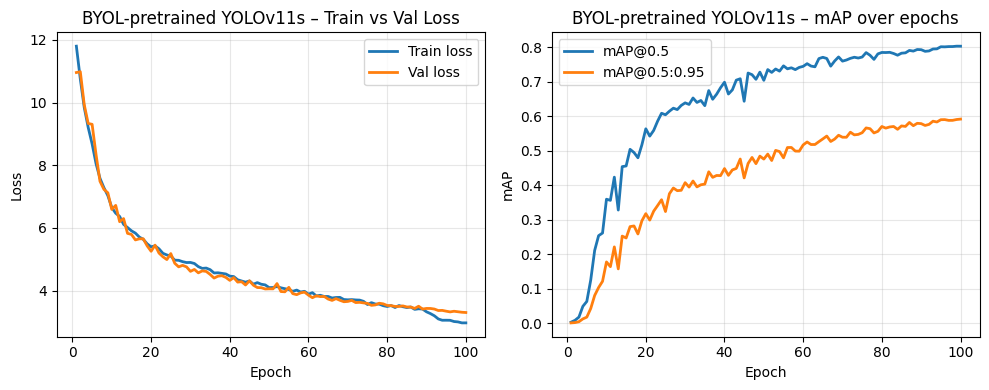

In [16]:
# ============================================================
# BYOL-pretrained YOLOv11s: train vs val loss & mAP
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Folder where your BYOL fine-tuning results were saved
run_dir = Path("/kaggle/working/disaster_yolo11s_byol_pretrained") / "yolo11s_disaster_byol"

csv_path = run_dir / "results.csv"
assert csv_path.exists(), f"results.csv not found at {csv_path}"

# Load results
df = pd.read_csv(csv_path)
epochs = df["epoch"]

# ---------------------------
# Compute train loss
# ---------------------------
train_loss = df["train/box_loss"] + df["train/cls_loss"]
if "train/dfl_loss" in df.columns:
    train_loss = train_loss + df["train/dfl_loss"]

# ---------------------------
# Compute val loss
# ---------------------------
val_loss = None
if {"val/box_loss", "val/cls_loss"}.issubset(df.columns):
    val_loss = df["val/box_loss"] + df["val/cls_loss"]
    if "val/dfl_loss" in df.columns:
        val_loss = val_loss + df["val/dfl_loss"]

# ---------------------------
# Extract metrics
# ---------------------------
map50 = df.get("metrics/mAP50(B)", None)
map5095 = df.get("metrics/mAP50-95(B)", None)

# ---------------------------
# Plotting
# ---------------------------
plt.figure(figsize=(10, 4))

# ---- Loss plot ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train loss", linewidth=2)

if val_loss is not None:
    plt.plot(epochs, val_loss, label="Val loss", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BYOL-pretrained YOLOv11s – Train vs Val Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# ---- mAP plot ----
plt.subplot(1, 2, 2)
if map50 is not None:
    plt.plot(epochs, map50, label="mAP@0.5", linewidth=2)
if map5095 is not None:
    plt.plot(epochs, map5095, label="mAP@0.5:0.95", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("BYOL-pretrained YOLOv11s – mAP over epochs")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Qualitative Comparison

Chosen test image: 3490.jpg


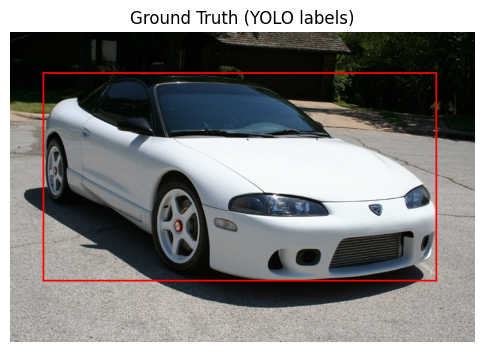


image 1/1 /kaggle/working/disaster_ssl/test/images/3490.jpg: 448x640 1 small_vehicle, 45.4ms
Speed: 1.9ms preprocess, 45.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


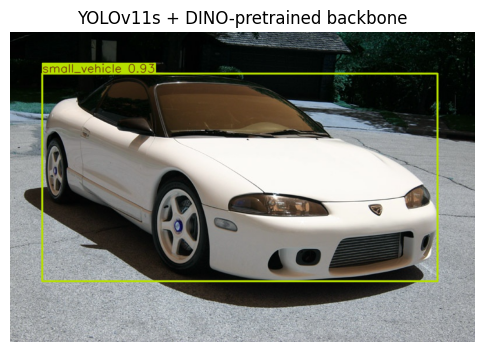


image 1/1 /kaggle/working/disaster_ssl/test/images/3490.jpg: 448x640 1 small_vehicle, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


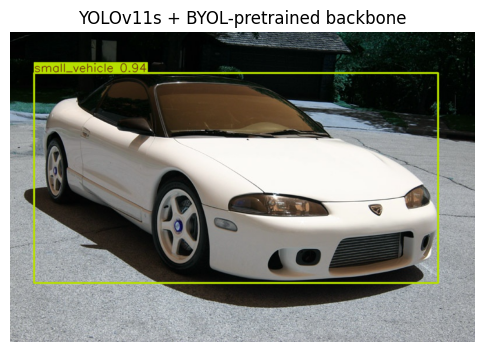

In [17]:
# ============================================================
# Qualitative comparison: one random test image across models
# ============================================================


import random
from pathlib import Path

import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image, ImageDraw

# -------------------------------
# Test dataset paths (YOUR dataset)
# -------------------------------
test_img_dir = Path("/kaggle/working/disaster_ssl/test/images")
test_label_dir = Path("/kaggle/working/disaster_ssl/test/labels")

# Collect .jpg/.png images
img_paths = sorted(test_img_dir.glob("*.jpg")) + sorted(test_img_dir.glob("*.png"))
assert img_paths, f"No images found under {test_img_dir}"

# Pick one random image
img_path = random.choice(img_paths)
print(f"Chosen test image: {img_path.name}")

# Load image
img = Image.open(img_path).convert("RGB")
W, H = img.size


# ============================================================
# 1) Draw Ground Truth YOLO Boxes
# ============================================================
gt_img = img.copy()
draw = ImageDraw.Draw(gt_img)

label_path = test_label_dir / f"{img_path.stem}.txt"

if label_path.exists():
    with open(label_path, "r") as f:
        for line in f:
            cls, xc, yc, w, h = map(float, line.split())

            # Convert YOLO → pixel coordinates
            x1 = (xc - w/2) * W
            y1 = (yc - h/2) * H
            x2 = (xc + w/2) * W
            y2 = (yc + h/2) * H

            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
else:
    print(f"Warning: no GT labels found for {img_path.name}")

plt.figure(figsize=(6, 6))
plt.imshow(gt_img)
plt.axis("off")
plt.title("Ground Truth (YOLO labels)")
plt.show()


# ============================================================
# 2) Run SSL Models on the SAME Image
# ============================================================

models = [
    ("YOLOv11s + DINO-pretrained backbone", YOLO(DINO_DET_WEIGHTS)),
    ("YOLOv11s + BYOL-pretrained backbone", YOLO(BYOL_DET_WEIGHTS)),
]

for title, model in models:
    # Single-image inference
    res = model(str(img_path), imgsz=640, conf=0.40)[0]

    # Convert prediction output to an image with drawn boxes
    pred_img = Image.fromarray(res.plot())

    plt.figure(figsize=(6, 6))
    plt.imshow(pred_img)
    plt.axis("off")
    plt.title(title)
    plt.show()
